In [1]:
%matplotlib inline

# Chapter1 ベイズ推論の考え方

## 例題1：司書か農家か？
- 事象
    - スティーブが農家であるか司書であるか
- 事前確率
    - P(司書)=1/21, P(農家)=20/21
- データ
    - スティーブの正確 → 内向的な性格


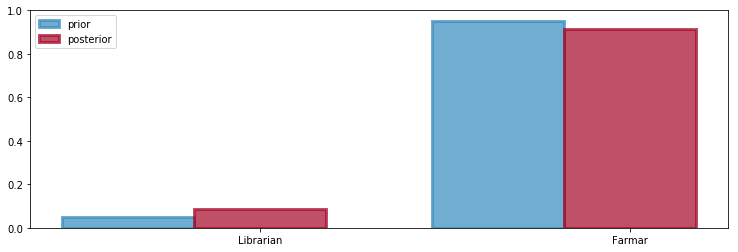

In [2]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(12.5, 4)

colors = ["#348abd", "#a60628"]

# 事前分布
prior = [1/21., 20/21.]
# 事後分布（手動で計算済み, ベイズ推定）
posterior = [0.087, 1-0.087]

# 事前確率のplot
plt.bar([0, .7], prior, alpha=0.7, width=0.25, color=colors[0], 
       label='prior', lw=3, edgecolor=colors[0])

# 事後分布のplot
plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7, width=0.25, color=colors[1], 
       label='posterior', lw=3, edgecolor=colors[1])
plt.xticks([0.25, 0.95], ['Librarian', 'Farmar'])
plt.legend()

## 例題2：メッセージ数に変化はあるか？
- ユーザが毎日受信するメッセージ数に変化点があるのか否か
- 事象：メッセージ受信数
- データ：ユーザが毎日受信するメッセージ数


<Container object of 74 artists>

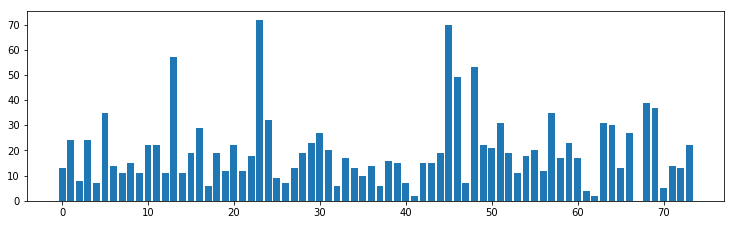

In [3]:
# データはgithubから取得(data/txtdata.csv)
figsize(12.5, 3.5)

# データの取り込みとplot
count_data = np.loadtxt('data/txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data)

# 40日くらいから増えているように見えないこともない

### モデル
- メッセージの受信数Cはポアソン分布とする
    - ある時期$\tau$で受信数に変化が起こったと仮定（変化がなければ予測したポアソン分布は差が無いように見えるはず）
    - ポアソン分布のパラメータ$\lambda$を予測する
    - $\lambda$の事前分布を指数分布として、指数分布のパラメータ$\alpha$はメッセージ受信数の逆数を初期値とする
- 変化点$\tau$は一様分布とする

### 変化点の推定

In [4]:
import pymc as pm

# lambdaの事前分布のパラメータalpha
alpha = 1.0 / count_data.mean()

# 予測する変数を確率的な変数として定義する
## stochastic変数
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

# シミュレーションのための決定的な変数を生成する関数
## deterministic変数
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    """
    シミュレーション用のlambdaの列を作る
    lambda_はtauが与えられれば、その前がlambda_1、後がlambda_2になる
    確率的に変化しないので、deterministicデコレータをつける
    """
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

# データの生成モデルのオブジェクトを作成
## 観測値=メッセージ受信数はポアソン分布としている
## ポアソン分布のパラメータlambdaはlambda_（tauでパラメータが変化している）
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

# Pymcのモデルインスタンスを生成
model = pm.Model([observation, lambda_1, lambda_2, tau])

# パラメータの推定
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000) # 40000回のMCMCステップ、10000回はバーンイン

 [-----------------100%-----------------] 40000 of 40000 complete in 7.6 sec

In [5]:
print(type(model))
print(type(mcmc))
print(type(observation))

<class 'pymc.Model.Model'>
<class 'pymc.MCMC.MCMC'>
<class 'pymc.distributions.new_dist_class.<locals>.new_class'>


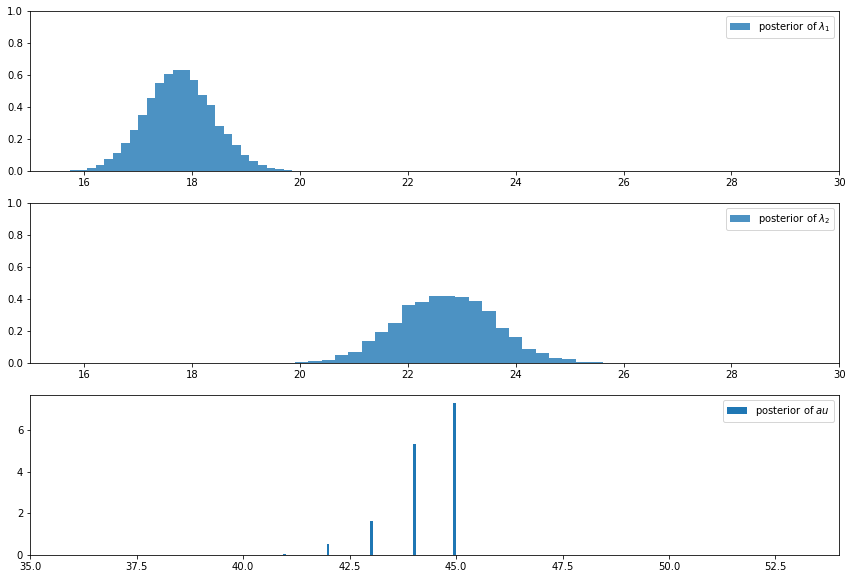

In [6]:
# 予測結果の確認

## mcmcシミュレーションの経過状態を取得
### traceメソッドではオブジェクトなので、配列を受け取るために[:]をつける
lambda_1_sample = mcmc.trace('lambda_1')[:]
lambda_2_sample = mcmc.trace('lambda_2')[:]
tau_sample = mcmc.trace('tau')[:]

figsize(14.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_sample, histtype='stepfilled', 
         bins=30, alpha=0.8, normed=True, label="posterior of $\lambda_1$")
plt.xlim([15, 30])
plt.legend()

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_sample, histtype='stepfilled', 
         bins=30, alpha=0.8, normed=True, label="posterior of $\lambda_2$")
plt.xlim([15, 30])
plt.legend()

ax = plt.subplot(313)
ax.set_autoscaley_on(True)
plt.hist(tau_sample, histtype='stepfilled', 
         bins=n_count_data, alpha=1.0, normed=True, label="posterior of $\tau$")
plt.xlim([35, len(count_data)-20])
plt.legend()


予測した事後分布から、2つの期間ではポアソン分布のパラメータが違っているようだ。
つまり、2つの期間でメッセージ数には変化があると見える。

変化の生じた日は、45日か44日であろうということもわかった。

### 事後分布からメッセージ受信数の期待値を計算
- 分布が変わったのはわかった
- 実際にどれくらいのメッセージを受け取るだろうと予測されるのか？

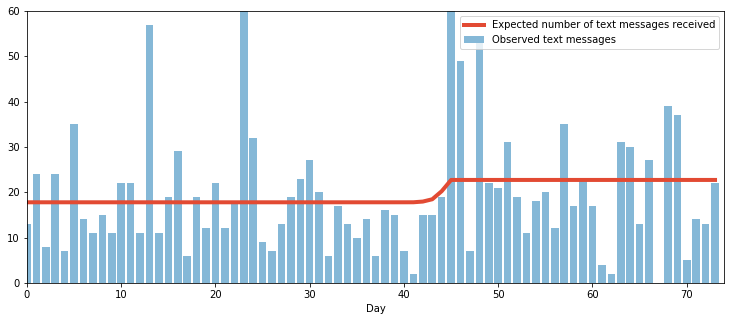

In [7]:
figsize(12.5, 5)

N = tau_sample.shape[0] # tauじゃなくても良くて、サンプルの数, MCMCの入力パラメータ
expected_texts_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    # 変化点の前後でパラメータ（ポアソン分布のパラメータlambda）が変化するので、
    # dayがtauのサンプルに対して、変化点の前か後かを示すbool値
    ix = day < tau_sample
    
    # 変化点の前ならlambda_1からのサンプル, 変化点の後ならlambda_2からのサンプル
    # ポアソン分布のパラメータlambdaは発生数の期待値なので、
    # lambda_1_sampleなどから直接サンプルしてきて、平均すれば良い
    expected_texts_per_day[day] = (lambda_1_sample[ix].sum() 
                                  + lambda_2_sample[~ix].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color='#e24a33', 
        label = 'Expected number of text messages received')
plt.xlim(0, n_count_data)
plt.ylim(0, 60)
plt.xlabel('Day')

plt.bar(np.arange(len(count_data)), count_data, color='#348abd', alpha=0.6, 
       label = 'Observed text messages')
plt.legend()

### 事後分布を使っていろいろ分析してみる

#### 2つの期間でパラメータが異なっているのは本当か？
- 上記では、明らかにパラメータの事後分布が異なっていると「目視」で確認した
- 定量的には如何ようにして測ったら良いか？
    - $P(\lambda_1 < \lambda_2 | data)$を計算する
    - つまり、事後分布のサンプルから、$\lambda_1 < \lambda_2$となる頻度を計算

In [8]:
gt_lambda2 = lambda_1_sample < lambda_2_sample
n_gt_lambda2 = gt_lambda2.sum()
N = lambda_1_sample.shape[0]
p_gt_lambda2 = n_gt_lambda2 / np.float(N)

print(n_gt_lambda2)
print(N)
print(p_gt_lambda2)

30000
30000
1.0


明らかに2つの分布は異なるようだ（マジで？バグない？）

### 変化点は一つなのか？
- 変化点が一つというのは、モデル設計者の感覚に依っている
- 2つの変化点があると仮定するとどうなるか？

In [9]:
# 予測する変数を確率的な変数として定義する
## 変化点が2回あると仮定すると、lambdaは3つ
## stochastic変数
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)
## 変化点が2つなので、tauを2つ用意
tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data-1)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)

# シミュレーションのための決定的な変数を生成する関数
## deterministic変数
@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2, 
            lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
    """
    シミュレーション用のlambdaの列を作る
    lambda_はtauが与えられれば、その前がlambda_1、後がlambda_2になる
    確率的に変化しないので、deterministicデコレータをつける
    """
    out = np.zeros(n_count_data)
    out[:tau_1] = lambda_1
    out[tau_1:tau_2] = lambda_2
    out[tau_2:] = lambda_3
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, 
                 lambda_1, lambda_2, lambda_3, 
                 tau_1, tau_2])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)


 [-----------------100%-----------------] 40000 of 40000 complete in 12.3 sec

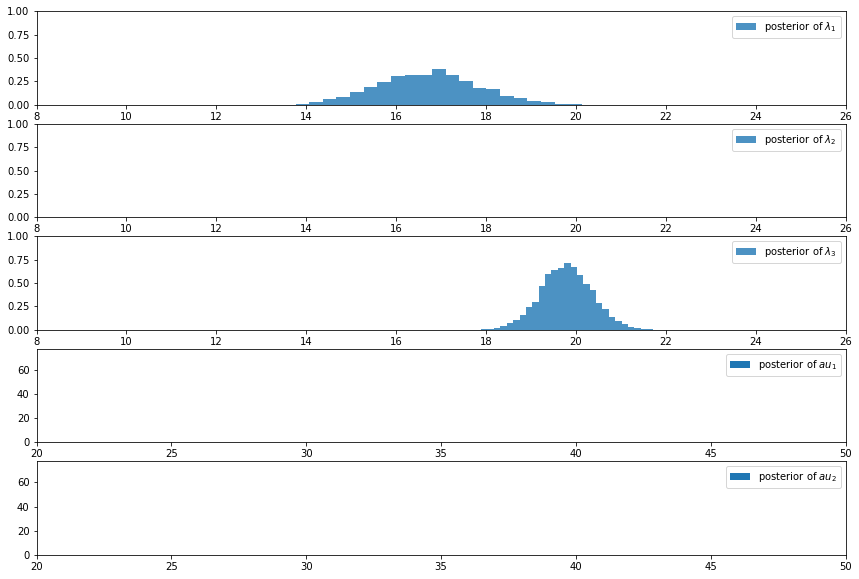

In [10]:
# 予測結果の確認

## mcmcシミュレーションの経過状態を取得
### traceメソッドではオブジェクトなので、配列を受け取るために[:]をつける
lambda_1_sample = mcmc.trace('lambda_1')[:]
lambda_2_sample = mcmc.trace('lambda_2')[:]
lambda_3_sample = mcmc.trace('lambda_3')[:]
tau1_sample = mcmc.trace('tau_1')[:]
tau2_sample = mcmc.trace('tau_2')[:]

figsize(14.5, 10)

ax = plt.subplot(511)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_sample, histtype='stepfilled', 
         bins=30, alpha=0.8, normed=True, label="posterior of $\lambda_1$")
plt.xlim([8, 26])
plt.legend()

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_sample, histtype='stepfilled', 
         bins=30, alpha=0.8, normed=True, label="posterior of $\lambda_2$")
#plt.xlim([15, 30])
plt.xlim([8, 26])
plt.legend()

ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_sample, histtype='stepfilled', 
         bins=30, alpha=0.8, normed=True, label="posterior of $\lambda_3$")
#plt.xlim([15, 30])
plt.xlim([8, 26])
plt.legend()

ax = plt.subplot(514)
ax.set_autoscaley_on(True)
plt.hist(tau1_sample, histtype='stepfilled', 
         bins=n_count_data, alpha=1.0, normed=True, label="posterior of $\tau_1$")
#plt.xlim([0, len(count_data)])
plt.xlim([20, 50])
plt.legend()

ax = plt.subplot(515)
ax.set_autoscaley_on(True)
plt.hist(tau2_sample, histtype='stepfilled', 
         bins=n_count_data, alpha=1.0, normed=True, label="posterior of $\tau_2$")
#plt.xlim([0, len(count_data)])
plt.xlim([20, 50])
plt.legend()
